In [43]:
# Heading 1
## Subheading 1.1
### Subheading 1.1.1
## Subheading 1.2
# Heading 2


# Project 3


#
**Problem Statement**
- Is it clear what the goal of the project is?
- What type of model will be developed?
- How will success be evaluated?
- Is the scope of the project appropriate?
- Is it clear who cares about this or why this is important to investigate?
- Does the student consider the audience and the primary and secondary stakeholders?

## Problem Statment: 

## 1. Using PRAW, you'll collect posts from two subreddits of your choosing.

In [44]:
#python -m pip install praw
import praw
import pandas as pd
import nltk
import pandas as np
import unicodedata
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,TfidfVectorizer
from sklearn.model_selection import train_test_split 
from textblob import Word
import numpy as np
import spacy
import re
import matplotlib.pyplot as plt

In [45]:
reddit = praw.Reddit(
    client_id='zus9cDU7x8IncmqOLReFYA',
    client_secret='3O1U8qnB3GGxPE4UtM3tpTq1qMuXfA',
    user_agent='Pro3',
    username='-__A__-',
    password=''
)

In [46]:
# Below is JUST an example of how you can use PRAW

# Choose your subreddit
subreddit_DataScience = reddit.subreddit('DataScience')
subreddit_wallstreetbets = reddit.subreddit('wallstreetbets')

# Adjust the limit as needed -- Note that this will grab the 25 most recent posts
posts_DS = subreddit_DataScience.new(limit=525)
posts_wsb = subreddit_wallstreetbets.new(limit=525)

In [47]:
data = []
for post in posts_DS:
    data.append([post.created_utc, post.title, post.selftext, post.subreddit])

# Turn into a dataframe
boardgames = pd.DataFrame(data, columns = ['created_utc', 'title', 'self_text', 'subreddit'])
boardgames.head()

,created_utc,title,self_text,subreddit
0,1.697705e+09,Seeking Advice for Universities for MSc in Dat...,I'm primarily considering Ireland but would l...,datascience
1,1.697704e+09,Different loss function than evaluation metric,"Hi all,\n\nI am currently writing my master th...",datascience
2,1.697703e+09,AI-facilitated religi...WHAT!,https://lumanai.church/,datascience
3,1.697703e+09,Market Timing & Risk Management - Portfolio al...,Hi everyone! \nIs it possible to create a mar...,datascience
4,1.697699e+09,Your Secret Weapon in the Job Hunt,"\n\nNovember is fast approaching, and as many...",datascience


In [48]:
data_wsb = []
for post in posts_wsb:
    data_wsb.append([post.created_utc, post.title, post.selftext, post.subreddit])

# Turn into a dataframe
boardgames_wsb = pd.DataFrame(data_wsb, columns = ['created_utc', 'title', 'self_text', 'subreddit'])
boardgames_wsb.head()

,created_utc,title,self_text,subreddit
0,1.697705e+09,Weekly TF,,wallstreetbets
1,1.697703e+09,Powell Speech Will Be Non-Event,Powell is speaking at 12 PM EST on Thursday. N...,wallstreetbets
2,1.697702e+09,Levels of convincingness for an argument,,wallstreetbets
3,1.697700e+09,NOKIA letter from CEO to employees... PUTS!,"Today, we’re announcing that Nokia targets to ...",wallstreetbets
4,1.697699e+09,3 Stocks That Can Be Potential Short Squeeze P...,,wallstreetbets


In [49]:
df = pd.concat([boardgames, boardgames_wsb])


In [50]:
df.subreddit.value_counts()

datascience       525
wallstreetbets    525
Name: subreddit, dtype: int64

In [51]:
df.head()

,created_utc,title,self_text,subreddit
0,1.697705e+09,Seeking Advice for Universities for MSc in Dat...,I'm primarily considering Ireland but would l...,datascience
1,1.697704e+09,Different loss function than evaluation metric,"Hi all,\n\nI am currently writing my master th...",datascience
2,1.697703e+09,AI-facilitated religi...WHAT!,https://lumanai.church/,datascience
3,1.697703e+09,Market Timing & Risk Management - Portfolio al...,Hi everyone! \nIs it possible to create a mar...,datascience
4,1.697699e+09,Your Secret Weapon in the Job Hunt,"\n\nNovember is fast approaching, and as many...",datascience


### 

In [52]:
#df['subreddit'] = df['subreddit'].map({'wallstreetbets': 0 , 'datascience': 1})

### Shuffling the DataFrame 

In [53]:
df = df.sample(frac = 1)
df[:10]

,created_utc,title,self_text,subreddit
18,1.697658e+09,Will Understanding Advanced Data Structures Ma...,"I'm a data scientist with 5 yoe now, and I've ...",datascience
517,1.696615e+09,Literally me,,wallstreetbets
490,1.696626e+09,Spy Gay Bear Formation,,wallstreetbets
31,1.697617e+09,Fuel consumption,Hello everyone \n\nI hope you have an amazing ...,datascience
392,1.696889e+09,Unity CEO John Riccitiello is retiring from ga...,Don't think this is gonna help.\n\n[https://ww...,wallstreetbets
341,1.697021e+09,Almost half of US listed firms have negative p...,,wallstreetbets
21,1.697655e+09,"What's better as a data scientist ""precursor r...",I've been offered the opportunity to transfer ...,datascience
186,1.697385e+09,VIX calls or UVXY shares for this Iran Israel ...,Also thinking about XOP to capture the oil sit...,wallstreetbets
190,1.697384e+09,Dumb Money Movie Lost $15M - Sony Please Post ...,No surprise here Sony\n\nYou failed miserably ...,wallstreetbets
443,1.695821e+09,GitHub - anaconda/state-of-data-science: Data ...,,datascience


### Fearture engineering and pre-processing

Merging title and self_text

In [54]:
df['post'] = df.apply(lambda row: f"title: {row['title']} text: {row['self_text']}", axis=1)
df.head()

,created_utc,title,self_text,subreddit,post
18,1.697658e+09,Will Understanding Advanced Data Structures Ma...,"I'm a data scientist with 5 yoe now, and I've ...",datascience,title: Will Understanding Advanced Data Struct...
517,1.696615e+09,Literally me,,wallstreetbets,title: Literally me text:
490,1.696626e+09,Spy Gay Bear Formation,,wallstreetbets,title: Spy Gay Bear Formation text:
31,1.697617e+09,Fuel consumption,Hello everyone \n\nI hope you have an amazing ...,datascience,title: Fuel consumption text: Hello everyone \...
392,1.696889e+09,Unity CEO John Riccitiello is retiring from ga...,Don't think this is gonna help.\n\n[https://ww...,wallstreetbets,title: Unity CEO John Riccitiello is retiring ...


In [55]:
df.drop(['title','self_text', 'created_utc'], axis=1, inplace=True)

In [56]:
df.head()

,subreddit,post
18,datascience,title: Will Understanding Advanced Data Struct...
517,wallstreetbets,title: Literally me text:
490,wallstreetbets,title: Spy Gay Bear Formation text:
31,datascience,title: Fuel consumption text: Hello everyone \...
392,wallstreetbets,title: Unity CEO John Riccitiello is retiring ...


### Preprocessing
I making use of Regex to remove numbers and links from the post and creating a new column called cleaned post with processed text.

In [57]:
pattern = r'\b\d+\b|http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
df['cleaned_post'] = df['post'].replace(pattern, '', regex=True)

# EDA
* Starting off with highest single word count.
* Highest bigrams count
* Highest trigram count

In [58]:
#intialize Coutvector
import pandas as pd 
from sklearn.feature_extraction.text import CountVectorizer

#intitialize CountVectorizer 
vectorizer = CountVectorizer()

In [59]:
#fit 
wm = vectorizer.fit_transform(df['cleaned_post'])

In [60]:
wm.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [61]:
df_vect_ex = pd.DataFrame(wm.toarray(), columns= vectorizer.get_feature_names_out(), index=df.index)

In [62]:
df_vect_ex

,06pm,0dte,0dtes,0s,0t,0th,1000s,100bps,100k,100m,...,ytd,yu,yummy,zero,zhuzh,zig,zillow,zone,zones,zoomer
18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
517,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
490,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
392,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
287,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
292,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
df_vect_ex['target_subreddit'] = df['subreddit']

In [64]:
Count_w = df_vect_ex.drop('target_subreddit', axis=1).sum().sort_values(ascending = False)

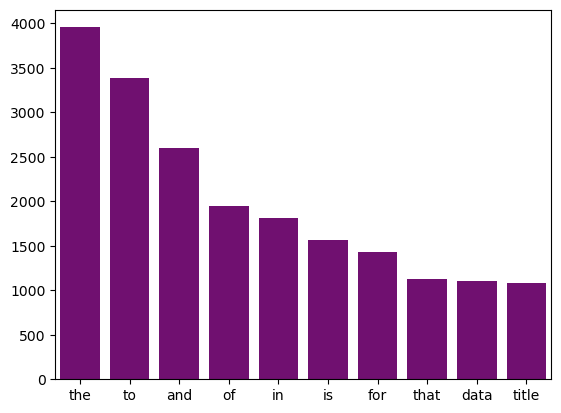

In [65]:
import seaborn as sns
sns.barplot(x=Count_w.index[:10], y = Count_w[:10], color='purple')
plt.show()

stop_words{‘english’}, list, default=None
If ‘english’, a built-in stop word list for English is used. There are several known issues with ‘english’ and you should consider an alternative (see Using stop words).

If a list, that list is assumed to contain stop words, all of which will be removed from the resulting tokens. Only applies if analyzer == 'word'.
If None, no stop words will be used. In this case, setting max_df to a higher value, such as in the range (0.7, 1.0), can automatically detect and filter stop words based on intra corpus document frequency of terms.

In [66]:
def gettopten(df):
    nv = CountVectorizer(stop_words='english', token_pattern= (r'\b(?!http\b|https\b|www\b|ftp\b)(?<!http)(?<!https)(?<!www)(?<!ftp)'
           r'\b[^\d\W]+\b(?!.[a-zA-Z0-9]+\b)'))
    nvv = nv.fit_transform(df['cleaned_post'])
    df_no = pd.DataFrame(nvv.toarray(), columns= nv.get_feature_names_out(), index= df.index)
    new_count = df_no.sum().sort_values(ascending=False)
    return sns.barplot(x=new_count.index[:10],y=new_count[:10], palette='colorblind') 


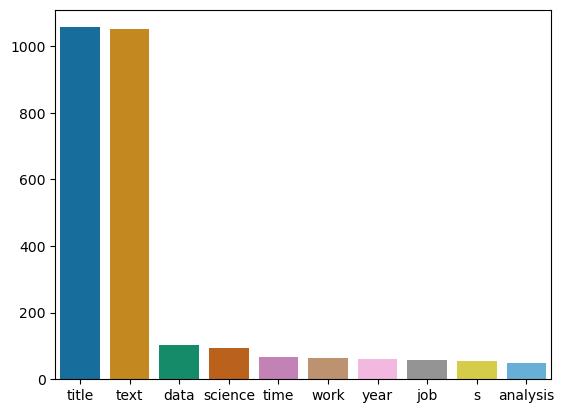

In [67]:
gettopten(df)
plt.show()

## Now we will check top 10 word counts in each subreddit

In [68]:
df[df['subreddit'] == 'datascience']

,subreddit,post,cleaned_post
18,datascience,title: Will Understanding Advanced Data Struct...,title: Will Understanding Advanced Data Struct...
31,datascience,title: Fuel consumption text: Hello everyone \...,title: Fuel consumption text: Hello everyone \...
21,datascience,"title: What's better as a data scientist ""prec...","title: What's better as a data scientist ""prec..."
443,datascience,title: GitHub - anaconda/state-of-data-science...,title: GitHub - anaconda/state-of-data-science...
95,datascience,title: Identity Crisis in Data Science text: A...,title: Identity Crisis in Data Science text: A...
...,...,...,...
171,datascience,title: Fraud Detection Machine learning projec...,title: Fraud Detection Machine learning projec...
178,datascience,title: Alphanumeric Search Algorithm? text: I ...,title: Alphanumeric Search Algorithm? text: I ...
287,datascience,title: Bayesian recommendations? text: Hello! ...,title: Bayesian recommendations? text: Hello! ...
292,datascience,title: Optimising Inputs to ML Model text: If ...,title: Optimising Inputs to ML Model text: If ...


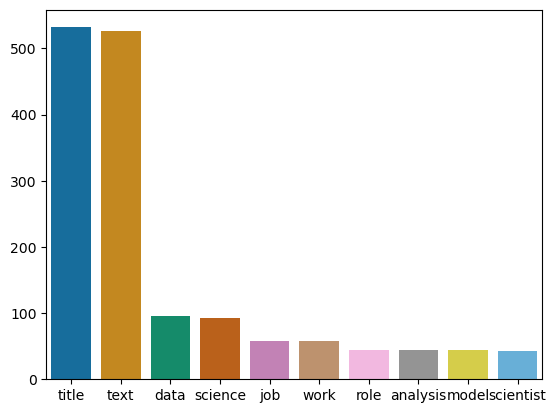

In [69]:
gettopten(df[df['subreddit'] == 'datascience'])
plt.show()

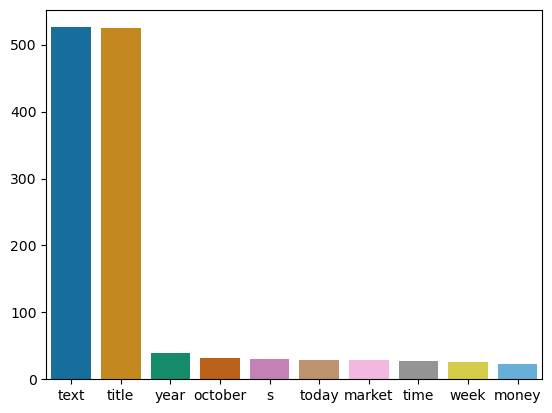

In [70]:
gettopten(df[df['subreddit'] == 'wallstreetbets'])
plt.show()

### We will use countvectorizer with ngram_range:
* ngram_range = (1,1) -> To do EDA on unigrams
* ngram_range = (2,2) -> To do EDA on bigrams
* ngram_range = (3,3) -> To do EDA on bigrams

In [71]:
def gettop10(df,n,stop='english'):
    cvec = CountVectorizer(ngram_range=(n,n), stop_words= stop)

    nvv = cvec.fit_transform(df['cleaned_post'])
    df_no = pd.DataFrame(nvv.toarray(), columns= cvec.get_feature_names_out(), index= df.index)
    new_count = df_no.sum().sort_values(ascending=False)
    plt.figure(figsize=(12,6))
    plt.tight_layout()
    return sns.barplot(x=new_count[:10],y=new_count.index[:10], palette='colorblind') 

## Top 10 highest occuring bigrams in the entire dataset

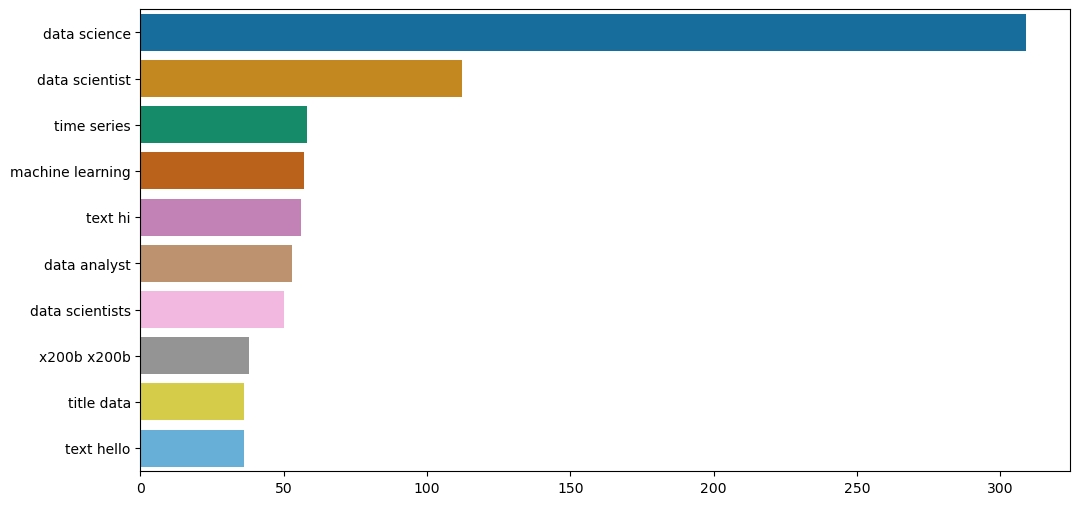

In [72]:
gettop10(df,2)
plt.show()

## Discovery:
There seems to be a word that appears frequently called `x200b`. Upon further investigation, this is the unicode for **whitespace character**. We will need to modify our post and remove this chracter with help of regex.

In [132]:
df['cleaned_post'] = df['cleaned_post'].replace(r'x200B|text|title|\n|\'', '', regex=True)

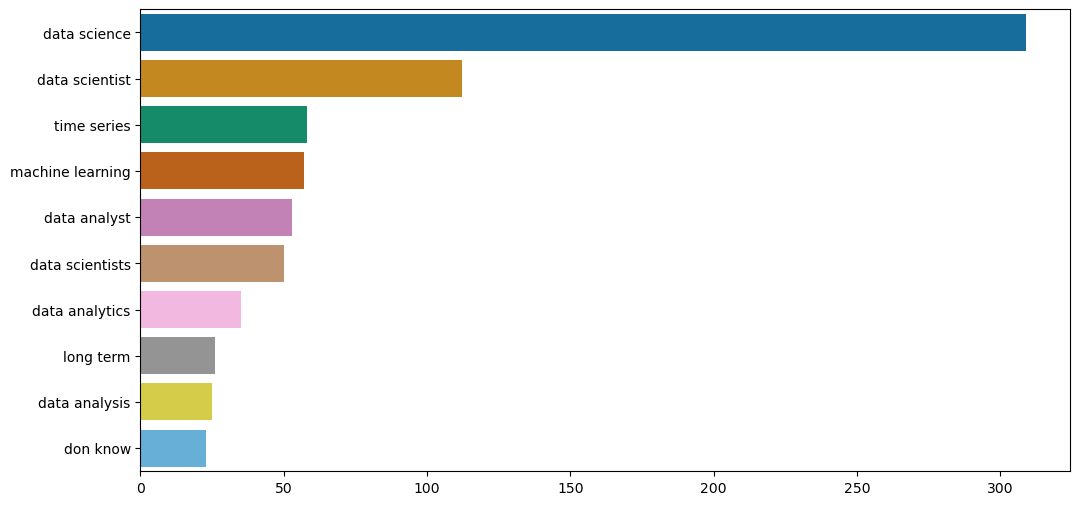

In [74]:
gettop10(df,2)
plt.show()

## Top 10 occurring bigrams in the wallstreetbets

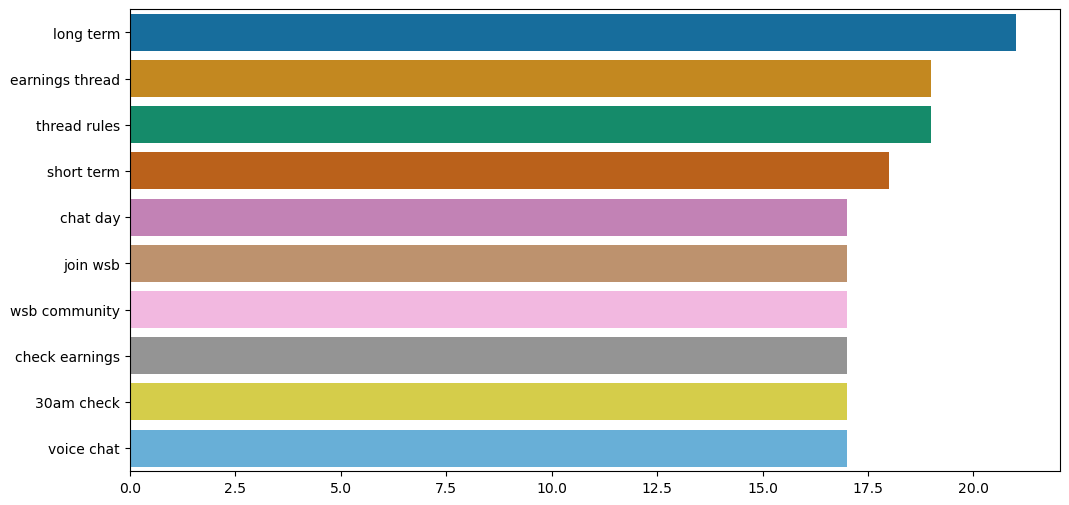

In [75]:
gettop10(df[df['subreddit'] == 'wallstreetbets'],2)
plt.show()

## Top 10 occurring bigrams in the datascience 

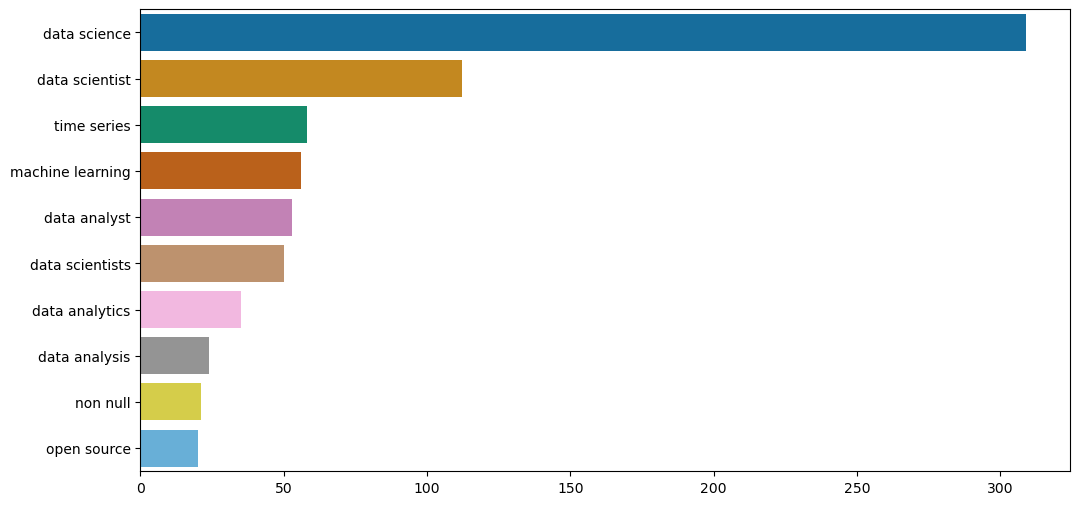

In [76]:
gettop10(df[df['subreddit'] == 'datascience'],2)
plt.show()

## Top 10 occurring trigrams in the wallstreetbets

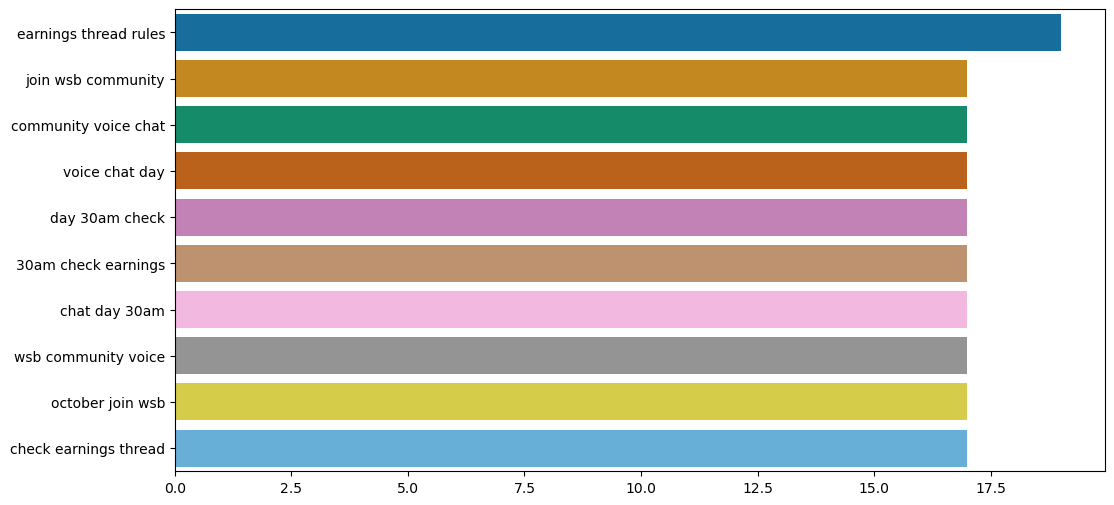

In [77]:
gettop10(df[df['subreddit'] == 'wallstreetbets'],3)
plt.show()

## Top 10 occurring trigrams in the datascience

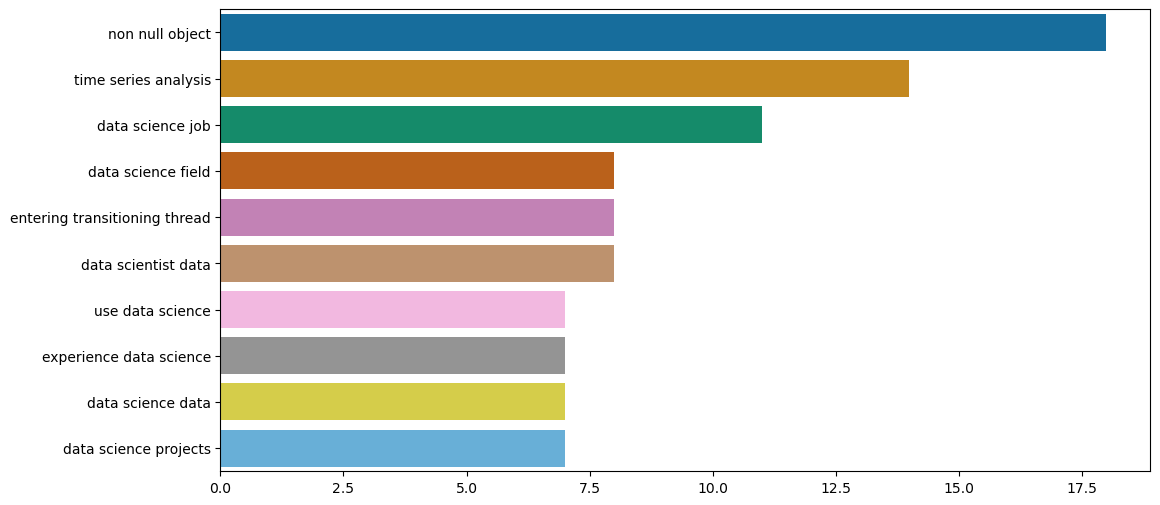

In [78]:
gettop10(df[df['subreddit'] == 'datascience'],3)
plt.show()

## Trigrams with stopwords

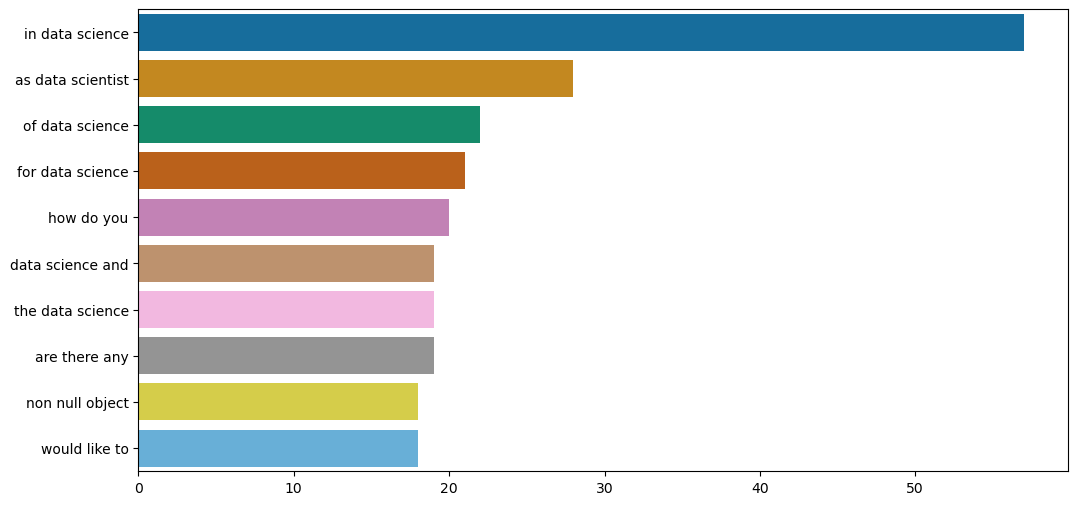

In [79]:
gettop10(df[df['subreddit'] == 'datascience'],3,stop=None)
plt.show()

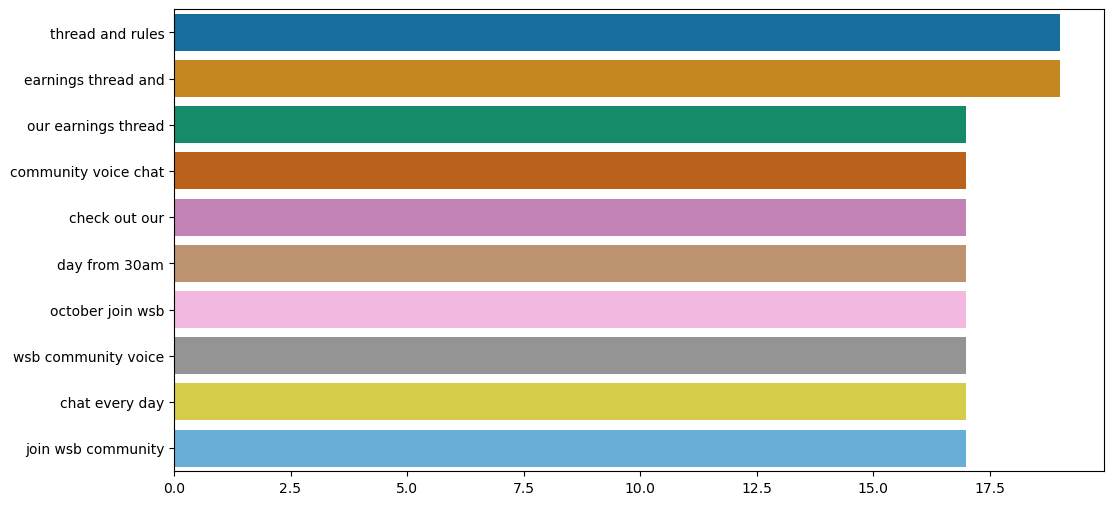

In [80]:
gettop10(df[df['subreddit'] == 'wallstreetbets'],3,stop=None)
plt.show()

## 4-gram with stopwords

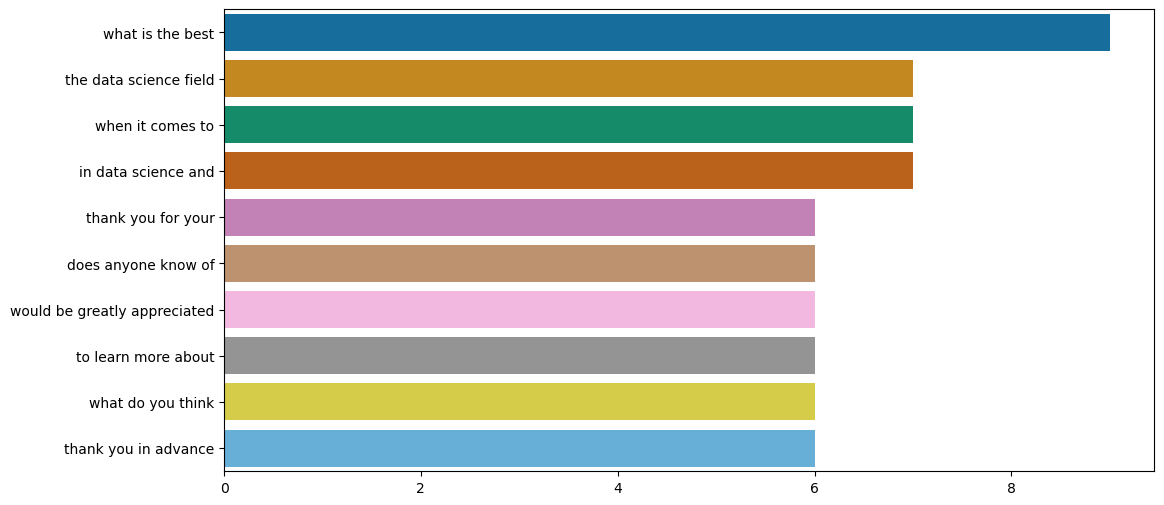

In [81]:
gettop10(df[df['subreddit'] == 'datascience'],4,stop=None)
plt.show()

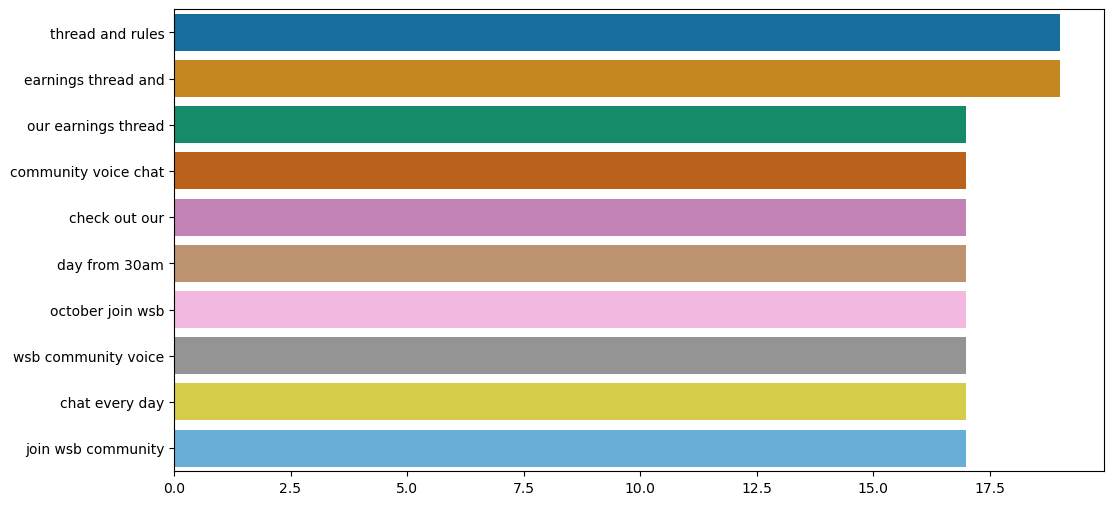

In [82]:
gettop10(df[df['subreddit'] == 'wallstreetbets'],3,stop=None)
plt.show()

## T-SNE Visulization

In [83]:
def tsne(df,n, stop='english'):
    cvec = CountVectorizer(ngram_range=(n,n), stop_words= stop)
    vectorized_matrix = cvec.fit_transform(df['cleaned_post'])
    df_vectorized_matrix = pd.DataFrame(vectorized_matrix.toarray(), columns= cvec.get_feature_names_out(), index= df.index)
    df_vectorized_matrix['Sne_lables']=df['subreddits']
    return  

In [84]:
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.feature_extraction.text import CountVectorizer
# import pandas as pd

# def tsne_viz(df, n, stop='english'):
#     # 1. Vectorize the text data
#     cvec = CountVectorizer(ngram_range=(n,n), stop_words=stop)
#     vectorized_matrix = cvec.fit_transform(df['cleaned_post'])
    
#     # 2. Compute t-SNE coordinates
#     tsne = TSNE(n_components=, random_state=42)
#     tsne_results = tsne.fit_transform(vectorized_matrix.toarray())
    
#     # 3. Plot the t-SNE coordinates
#     plt.figure(figsize=(12,8))
#     sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], hue=df['subreddit'], palette="deep", edgecolor="w", s=60)
#     plt.title('t-SNE Visualization')
#     plt.xlabel('t-SNE Dimension 1')
#     plt.ylabel('t-SNE Dimension 2')
#     plt.show()

# # Sample usage
# # tsne_viz(your_dataframe, 1)


In [85]:
#tsne_viz(df, 3, stop='english')

In [86]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

def tsne_viz_3d(df, n, stop='english'):
    # 1. Vectorize the text data
    cvec = CountVectorizer(ngram_range=(n,n), stop_words=stop)
    vectorized_matrix = cvec.fit_transform(df['cleaned_post'])
    
    # 2. Compute t-SNE coordinates for 3D
    tsne = TSNE(n_components=3, random_state=42)
    tsne_results = tsne.fit_transform(vectorized_matrix.toarray())
    
    # 3. Plot the t-SNE coordinates in 3D
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, projection='3d')
    
    scatter = ax.scatter(tsne_results[:,0], tsne_results[:,1], tsne_results[:,2], 
                         c=pd.factorize(df['subreddit'])[0], cmap="viridis", s=60)
    
    legend1 = ax.legend(*scatter.legend_elements(), title="Subreddits")
    ax.add_artist(legend1)
    
    ax.set_title('3D t-SNE Visualization')
    ax.set_xlabel('t-SNE Dimension 1')
    ax.set_ylabel('t-SNE Dimension 2')
    ax.set_zlabel('t-SNE Dimension 3')
    
    plt.show()

# Sample usage
# tsne_viz_3d(your_dataframe, 1)


c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


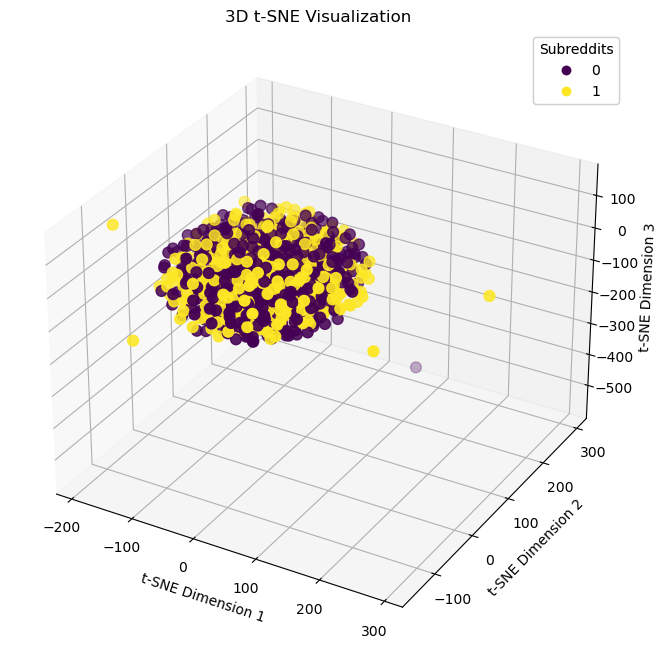

In [87]:
tsne_viz_3d(df, 3, stop='english')

In [88]:
import plotly.express as px
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

def tsne_viz_3d_interactive(df, n, stop='english'):
    # 1. Vectorize the text data
    cvec = CountVectorizer(ngram_range=(n,n), stop_words=stop)
    vectorized_matrix = cvec.fit_transform(df['cleaned_post'])
    
    # 2. Compute t-SNE coordinates for 3D
    tsne = TSNE(n_components=3, random_state=42)
    tsne_results = tsne.fit_transform(vectorized_matrix.toarray())
    
    # Create a DataFrame for plotting
    df_tsne = pd.DataFrame(tsne_results, columns=['dim1', 'dim2', 'dim3'])
    df_tsne['subreddit'] = df['subreddit'].reset_index(drop=True)
    
    # 3. Plot using plotly
    fig = px.scatter_3d(df_tsne, x='dim1', y='dim2', z='dim3', color='subreddit')
    fig.show()

# Sample usage
# tsne_viz_3d_interactive(your_dataframe, 1)


In [89]:
tsne_viz_3d_interactive(df, 3, stop='english')

c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [129]:
import plotly.express as px
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

def tsne_viz_3d_interactive_with_index(df, n, stop='english'):
    # 1. Vectorize the text data
    cvec = CountVectorizer(ngram_range=(n,n), stop_words=stop)
    vectorized_matrix = cvec.fit_transform(df['cleaned_post'])
    
    # 2. Compute t-SNE coordinates for 3D
    tsne = TSNE(n_components=3, random_state=42)
    tsne_results = tsne.fit_transform(vectorized_matrix.toarray())
    
    # Create a DataFrame for plotting
    df_tsne = pd.DataFrame(tsne_results, columns=['dim1', 'dim2', 'dim3'])
    df_tsne['subreddit'] = df['subreddit'].reset_index(drop=True)
    df_tsne['index'] = df.index  # Add the index as a column
    
    # 3. Plot using plotly with hover data
    fig = px.scatter_3d(df_tsne, x='dim1', y='dim2', z='dim3', color='subreddit', hover_data=['index'])
    fig.show()

# Sample usage
# tsne_viz_3d_interactive_with_index(your_dataframe, 1)


In [133]:
tsne_viz_3d_interactive_with_index(df, 3, stop='english')

c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [135]:
df.iloc[35]['cleaned_post']

': How do we know that the SQL query will return the correct solution? : SQL and I are just "getting to know each other" with the help of some courses and a book. Please help me with the theoretical and naive question of how does one know that a query returns the correct and presumably the one and only correct solution? This is clearly verifiable in the case of practice problems and although I dont get it right the first time, this is exactly what makes me think that in the real world I cannot be sure of the correctness of a query.Perhaps my question can be translated as how to validate a SQL query?Thanks if you share your experiences.'

In [112]:
df.iloc[291]['cleaned_post']

': How to recover from submitting incorrect résumé for job application? : Hi, I majorly fucked up.\n\nI currently work as a statistician in biotech and am looking to transition to a data science career. I worked a very long day yesterday due to standard end of quarter rush, and so when I got home, I spent all evening completely revamping from top to bottom my LinkedIn and Resume.\n\nThe problem is my resume. I found this template online that looked great ( and began filling it out. The fuck up is on the education section. I had filled out the bullet points saying when I had finished my undergrad and masters as well as the relevant coursework I took, but I submitted this new resume to a job (that looked like something I’d absolutely love and be qualified for) with the education section saying I spent all my time at the University of Pennsylvania (what the template lists as the only school — I didn’t go to this school nor did I do my undergrad and masters at the same school). \n\nHow sho

In [113]:
df.iloc[520]['cleaned_post']

': My strategy is simple… : I’m betting on something that’ll not come true. High upside, low downside.'

In [114]:
df.iloc[463]['cleaned_post']

': How do you send data in batches to an open source LLM to be processed on GPU : Say for eg. I am doing sentiment analysis using Llama . I have daily news articles which I wish to get daily sentiment ratings.\n\nRather than looping daily in my Python script or prompt template, how do I send say  days of daily news in a batch to Llama  to get back  daily sentiment ratings in one go so that I am fully utilizing my GPU resources?'

In [136]:
import re # Source Chat GPT

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    
    # Remove Emojis
    emoji_pattern = re.compile(
        u"([\U00002600-\U000027BF])|"  # Misc symbols
        u"([\U0001F600-\U0001F64F])|"  # Emoticons
        u"([\U0001F300-\U0001F5FF])|"  # Symbols & pictographs
        u"([\U0001F680-\U0001F6FF])|"  # Transport & map symbols
        u"([\U0001F700-\U0001F77F])|"  # Alchemical symbols
        u"([\U0001F780-\U0001F7FF])|"  # Geometric shapes ext
        u"([\U0001F800-\U0001F8FF])|"  # Supplemental arrows C
        u"([\U0001F900-\U0001F9FF])|"  # Supplemental symbols
        u"([\U0001FA00-\U0001FA6F])|"  # Chess symbols
        u"([\U0001FA70-\U0001FAFF])"   # Symbols and pictographs ext A
        , re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # Remove excessive whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Remove placeholder text
    text = re.sub(r'Daily Discussion Thread for [A-Za-z\s]+,', '', text)
    
    return text


In [137]:
df2 = df.copy()

In [138]:
df2['cleaned_post'] = df2['cleaned_post'].apply(clean_text)

In [139]:
tsne_viz_3d_interactive_with_index(df2, 3, stop='english')

c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [140]:
df2.iloc[118]['cleaned_post']

': Show me the dip where your Grandpa lost all his money! :'

In [142]:
df2.iloc[406]['cleaned_post']

': Sucking at my job? : Got into my first job about months ago. I study a master’s on data science and I’m about to finish school in - months. I’m doing okay, my lowest score is B+ and I’m working on a churn project. I got my job through a friend, the company knew I was recently starting my master’s and that I had no experience in this field. However, they were really interested in what I was (supposedly) going to learn, and were excited that I’d bring a new perspective to the team. Things started ok and I’m doing pretty good on every day tasks, but whenever I’m handed an analysis task/data science project, it always ends up taking more time than allowed, and the more experienced people in my team usually end up coming in and having to re-do everything, sometimes even work overtime to meet deadlines. It’s not that I’m not working on it, like for example I have about hours on this one project I had to do, and all I have is a few tables and metrics. Yet, the customer meeting is tomorrow 

In [120]:
tsne_viz_3d_interactive_with_index(df2, 4, stop='english')

c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [143]:
df2.iloc[463]["cleaned_post"]

': How do you send data in batches to an open source LLM to be processed on GPU : Say for eg. I am doing sentiment analysis using Llama . I have daily news articles which I wish to get daily sentiment ratings.Rather than looping daily in my Python script or prompt template, how do I send say days of daily news in a batch to Llama to get back daily sentiment ratings in one go so that I am fully utilizing my GPU resources?'

In [107]:
tsne_viz_3d_interactive_with_index(df2, 5, stop=None)

c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



After further cleaning the text, we can see the that some of the outliers have been removed and the overall dimansanality of the tsne has been compressed.


## Modeling

In [146]:
X= df2['cleaned_post']
y=df2['subreddit']

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)

Using the TFidifVectorizer

In [152]:
#Instantiate 
tvec = TfidfVectorizer(stop_words='english', ngram_range=(1,2))

In [153]:
X_train_df = pd.DataFrame(tvec.fit_transform(X_train).toarray(), columns = tvec.get_feature_names_out()) 

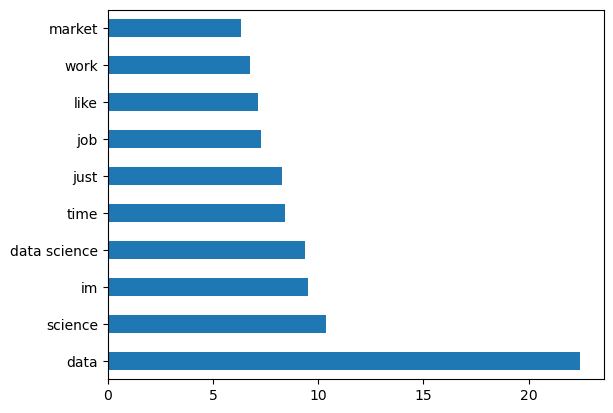

In [154]:
X_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh');

In [ ]:
# Instantiate (w/ ngrams)
cvec = CountVectorizer(stop_words='english', ngram_range=(1, 2), min_df=2)

#Fit
cvec.fit(X_train)

#Transform
X_train_cv = cvec.transform(X_train)
X_test_cv = cvec.transform(X_test)

In [ ]:
X_train_cv.shape

(787, 5830)

In [ ]:
# Convert X_train into a DataFrame.
# We will not actually use this for modeling,
# this is just to visualize what is happening

X_train_df = pd.DataFrame(X_train_cv.todense(), columns=cvec.get_feature_names())

c:\Users\muham\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


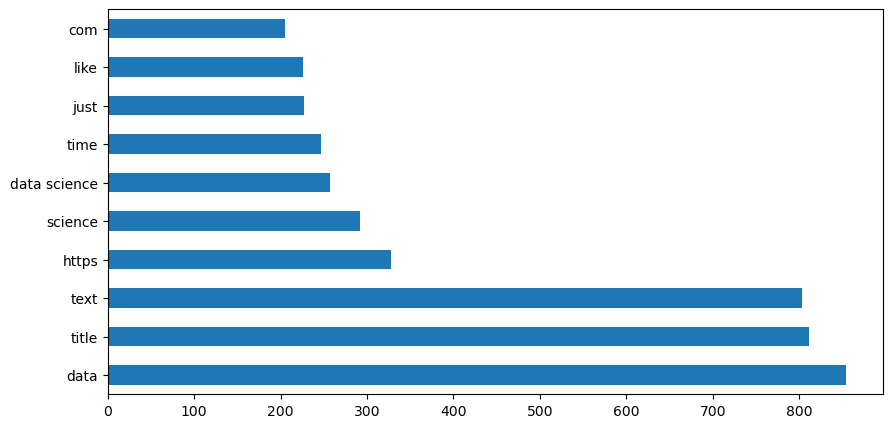

In [ ]:
# Plot top occuring words

plt.figure(figsize=(10, 5))
X_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh');

In [ ]:
cvec.score(X_train, y_train)

AttributeError: 'CountVectorizer' object has no attribute 'score'

# Peform similar EDA for Unigram, bigram and Trigrams

## EDA on unique users

Because we have many posts per user for most users, doing EDA on the personality score columns might be misleading. If we have 200 Facebook statuses from one very high-conscientiousness user, a bar chart of how many `'cCON'` statuses are associated with `'y'` might be misleading. We'll have to be careful about labeling and titling any visualizations we make off of the dataset.

#### Create a new dataframe called `unique_users` that only contains the `#AUTHID`, personality score, and personality category columns:

If you do this correctly, it should have 250 rows and 11 columns.

(Hint: You can use the pandas [drop_duplicates()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html) method to make this easier. The only column you want to consider when deciding if a user is duplicated is the `#AUTHID` column.)

---

## EDA on Word Counts

### Vectorize the text

In order to perform EDA on word count data, we'll need to count-vectorize.

Create a dataframe that contains the count-vectorized text for each Facebook status in the dataset.

To do this, you might follow these steps:
- Instantiate a `CountVectorizer` object
- Fit the count vectorizer on the Facebook statuses
- Store the transformed data
- Convert to a dataframe and store
    - Don't forget that the transformed data will need to be 'densified'. The `toarray()` or `todense()` methods will allow this.
    - Don't forget that the `get_feature_names()` method on a fitted `CountVectorizer` object will bring you back the words learned from the dataset, which you can set as the `columns` argument when creating the dataframe.
    
It's up to you whether or not to keep stopwords in the dataset.

## Most common words based on personality category

In order to do more targeted EDA, we'll need to be able to reference not only the dataframe of vectorized statuses, but also the personality scores from the original dataframe.

#### Create a new dataframe called `text_and_scores` that concatenates the count-vectorized statuses side-by-side with the original personality category columns:

#### Other visualizations:

Create 1-2 additional visualizations related to the `unique_users` dataframe.

You might consider:
- Barcharts of users per category per trait
- A seaborn correlation heatmap
- A seaborn pairplot

_________________

import datetime
 
unixToDatetime = datetime.datetime.fromtimestamp(1661324766) # Unix Time
print(unixToDatetime)

In [ ]:
#Expanding Contractions (Source : Dipanjan-Sarkar-Text-Analytics-with-Python; Sarkar, Dipanjan)

from contractions import CONTRACTION_MAP
import re
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
 contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), flags=re.IGNORECASE|re.DOTALL)
 def expand_match(contraction):
    match = contraction.group(0)
    first_char = match[0]
    expanded_contraction = contraction_mapping.get(match)\
                            if contraction_mapping.get(match)\
                            else contraction_mapping.get(match.lower())
    expanded_contraction = first_char+expanded_contraction[1:]
    return expanded_contraction
 expanded_text = contractions_pattern.sub(expand_match, text)
 expanded_text = re.sub("'", "", expanded_text)
 return expanded_text


In [ ]:
#Correcting Repeating Characters
def remove_repeated_characters(tokens):
    repeat_pattern = re.compile(r'(\w*)(\w)\2(\w*)')
    match_substitution = r'\1\2\3'
    def replace(old_word):
        if wordnet.synsets(old_word):
            return old_word
        new_word = repeat_pattern.sub(match_substitution, old_word)
        return replace(new_word) if new_word != old_word else new_word
    correct_tokens = [replace(word) for word in tokens]
    return correct_tokens

In [ ]:
default_st = nltk.sent_tokenize
#alice_sentences = default_st(text=boardgames['self_text'])
boardgames['tokenized_sentences'] = boardgames['self_text'].apply(nltk.sent_tokenize)
all_sentences = [sentence for post_sentences in boardgames['tokenized_sentences'] for sentence in post_sentences]

#sample_sentences = default_st(text=sample_text)

In [ ]:
all_sentences

['I have a strong belief that the best data projects are the most personal ones.',
 'The ones that are clearly made by, well, you.',
 "To make them personal, this often means that you have to learn some skills that aren't exactly data science related.",
 "It's difficult to make something personal with just a Jupyter Notebook.",
 'Projects should look pretty, be easily accessible on the web, and free for both you and the user.',
 'We use PythonAnywhere to get this done for most of our portfolio projects.',
 'Some of the skills that will really help make a great project, that would compliment your data skills, are:\n\n\\- HTML\n\n\\- CSS\n\n\\- Web development (Flask, Django, Node)\n\n\\- Tableau - Cloud (GCP, AWS)\n\n\\- ...',
 'Anything that you find interesting\n\nThat last point is important.',
 'I often get asked how to come up with ideas.',
 'The best ideas come from whatever you are truly passionate about, and by not limiting yourself by trapping your skillset in an imaginary box.

In [ ]:
default_wt = nltk.word_tokenize
words = [nltk.word_tokenize(sentence) for sentence in all_sentences]
array_words = np.array([word for sentence in words for word in sentence])


In [ ]:
expanded_words = [expand_contractions(word) for word in array_words]


In [ ]:
cleaned_words = [remove_special_characters(word) for word in expanded_words]


In [ ]:
final_text = cleaned_words



In [ ]:
#Removing Stopwords2
#stopwords_removed = remove_stopwords(lemmatized)


Parts of Speech Tagging:
sentence → clauses → phrases → words

In [ ]:
#Using TfidfTransformer
tt = TfidfTransformer(norm='l2', use_idf=True)
tt_matrix = tt.fit_transform(cv_matrix)
tt_matrix = tt_matrix.toarray()
vocab = cv.get_feature_names()
pd.DataFrame(np.round(tt_matrix, 2), columns=vocab)

NameError: name 'cv_matrix' is not defined

In [ ]:
from collections import Counter
# build bag of words features for each document - term frequencies
bow_features = []
for doc in norm_corpus_list:
    bow_feature_doc = Counter(doc.split())
    all_features = Counter(def_feature_dict)
    bow_feature_doc.update(all_features)
    bow_features.append(bow_feature_doc)
bow_features = pd.DataFrame(bow_features)
bow_features

,question,role,work,sol,monkey,fang,masters,able,get,interview,...,local,coffee,shop,chain,last,chance,without,smash,strategy,uk
0,4,7,20,2,1,1,2,5,14,6,...,1,1,1,1,1,1,1,1,1,1


In [ ]:
import scipy.sparse as sp
feature_names = list(bow_features.columns)
# build the document frequency matrix
df = np.diff(sp.csc_matrix(bow_features, copy=True).indptr)
df = 1 + df # adding 1 to smoothen idf later
# show smoothened document frequencies
pd.DataFrame([df], columns=feature_names)

,question,role,work,sol,monkey,fang,masters,able,get,interview,...,local,coffee,shop,chain,last,chance,without,smash,strategy,uk
0,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


In [ ]:
# compute inverse document frequencies
total_docs = 1 + len(norm_corpus_list)
idf = 1.0 + np.log(float(total_docs) / df)
# show smoothened idfs
pd.DataFrame([np.round(idf, 2)], columns=feature_names)

,question,role,work,sol,monkey,fang,masters,able,get,interview,...,local,coffee,shop,chain,last,chance,without,smash,strategy,uk
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
#Constructing an n-verse document frequency diagonal matrix for each
# feature in our corpusConstructing an n-verse document frequency diagonal matrix for each
# feature in our corpus

# compute idf diagonal matrix
total_features = bow_features.shape[1]
idf_diag = sp.spdiags(idf, diags=0, m=total_features, n=total_features)
idf_dense = idf_diag.todense()
# print the idf diagonal matrix
pd.DataFrame(np.round(idf_dense, 2))

,0,1,2,3,4,5,6,7,8,9,...,678,679,680,681,682,683,684,685,686,687
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
683,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
685,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
# compute tfidf feature matrix
tf = np.array(bow_features, dtype='float64')
tfidf = tf * idf
# view raw tfidf feature matrix
pd.DataFrame(np.round(tfidf, 2), columns=feature_names)

,question,role,work,sol,monkey,fang,masters,able,get,interview,...,local,coffee,shop,chain,last,chance,without,smash,strategy,uk
0,4.0,7.0,20.0,2.0,1.0,1.0,2.0,5.0,14.0,6.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
from numpy.linalg import norm
# compute L2 norms
norms = norm(tfidf, axis=1)
# print norms for each document
print (np.round(norms, 3))

[80.443]


In [ ]:
# compute normalized tfidf
norm_tfidf = tfidf / norms[:, None]
# show final tfidf feature matrix
pd.DataFrame(np.round(norm_tfidf, 2), columns=feature_names)

,question,role,work,sol,monkey,fang,masters,able,get,interview,...,local,coffee,shop,chain,last,chance,without,smash,strategy,uk
0,0.05,0.09,0.25,0.02,0.01,0.01,0.02,0.06,0.17,0.07,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01


## 2. You'll then use NLP to train a classifier on which subreddit a given post came from. This is a binary classification problem.

For Project 3 the evaluation categories are as follows:
The Data Science Process

Problem Statement

Data Collection

Data Cleaning & EDA :

-->Removing HTML tags
• Tokenization
• Removing unnecessary tokens and stopwords
• Handling contractions
• Correcting spelling errors
• Stemming
• Lemmatization
• Tagging
• Chunking
• Parsing

AKA

 Clean the text data: Remove special characters, URLs, and numbers, and convert to lowercase.
__Tokenize the text and remove stopwords.__
__Vectorize the text using techniques like TF-IDF (Term Frequency-Inverse Document Frequency) or word embeddings.__


Preprocessing & Modeling: Split the data into training and testing sets.
Train a binary classification model. Common choices for text data include Logistic Regression, Naive Bayes, or more complex models like LSTM (Long Short-Term Memory) or Transformer-based models.
Evaluate the model on the test set to understand its accuracy and other metrics.

Evaluation and Conceptual Understanding: Use metrics like accuracy, precision, recall, and the F1 score to evaluate the model's performance.
Adjust hyperparameters or try different models if needed.

Deployment (Optional):

If you're satisfied with the model's performance, you can deploy it as an API or integrate it into an application.

Conclusion and Recommendations:


Rubric
Your instructors will evaluate your project (for the most part) using the following criteria. You should make sure that you consider and/or follow most if not all of the considerations/recommendations outlined below while working through your project.

For Project 3 the evaluation categories are as follows:
The Data Science Process

Problem Statement
Data Collection
Data Cleaning & EDA
Preprocessing & Modeling
Evaluation and Conceptual Understanding
Conclusion and Recommendations
Organization and Professionalism

Organization
Visualizations
Python Syntax and Control Flow
Presentation
Scores will be out of 30 points based on the 10 categories in the rubric.
3 points per section

Score	Interpretation
0	Project fails to meet the minimum requirements for this item.
1	Project meets the minimum requirements for this item, but falls significantly short of portfolio-ready expectations.
2	Project exceeds the minimum requirements for this item, but falls short of portfolio-ready expectations.
3	Project meets or exceeds portfolio-ready expectations; demonstrates a thorough understanding of every outlined consideration.
The Data Science Process
Problem Statement

Is it clear what the goal of the project is?
What type of model will be developed?
How will success be evaluated?
Is the scope of the project appropriate?
Is it clear who cares about this or why this is important to investigate?
Does the student consider the audience and the primary and secondary stakeholders?
Data Collection

Was enough data gathered to generate a significant result? (At least 1000 posts per subreddit)
Was data collected that was useful and relevant to the project?
Was data collection and storage optimized through custom functions, pipelines, and/or automation?
Was thought given to the server receiving the requests such as considering number of requests per second?
Data Cleaning and EDA

Are missing values imputed/handled appropriately?
Are distributions examined and described?
Are outliers identified and addressed?
Are appropriate summary statistics provided?
Are steps taken during data cleaning and EDA framed appropriately?
Does the student address whether or not they are likely to be able to answer their problem statement with the provided data given what they've discovered during EDA?
Preprocessing and Modeling

Is text data successfully converted to a matrix representation?
Are methods such as stop words, stemming, and lemmatization explored?
Does the student properly split and/or sample the data for validation/training purposes?
Does the student test and evaluate a variety of models to identify a production algorithm (AT MINIMUM: two models)?
Does the student defend their choice of production model relevant to the data at hand and the problem?
Does the student explain how the model works and evaluate its performance successes/downfalls?
Evaluation and Conceptual Understanding

Does the student accurately identify and explain the baseline score?
Does the student select and use metrics relevant to the problem objective?
Does the student interpret the results of their model for purposes of inference?
Is domain knowledge demonstrated when interpreting results?
Does the student provide appropriate interpretation with regards to descriptive and inferential statistics?
Conclusion and Recommendations

Does the student provide appropriate context to connect individual steps back to the overall project?
Is it clear how the final recommendations were reached?
Are the conclusions/recommendations clearly stated?
Does the conclusion answer the original problem statement?
Does the student address how findings of this research can be applied for the benefit of stakeholders?
Are future steps to move the project forward identified?
Organization and Professionalism
Project Organization

Are modules imported correctly (using appropriate aliases)?
Are data imported/saved using relative paths?
Does the README provide a good executive summary of the project?
Is markdown formatting used appropriately to structure notebooks?
Are there an appropriate amount of comments to support the code?
Are files & directories organized correctly?
Are there unnecessary files included?
Do files and directories have well-structured, appropriate, consistent names?
Visualizations

Are sufficient visualizations provided?
Do plots accurately demonstrate valid relationships?
Are plots labeled properly?
Are plots interpreted appropriately?
Are plots formatted and scaled appropriately for inclusion in a notebook-based technical report?
Python Syntax and Control Flow

Is care taken to write human readable code?
Is the code syntactically correct (no runtime errors)?
Does the code generate desired results (logically correct)?
Does the code follows general best practices and style guidelines?
Are Pandas functions used appropriately?
Are sklearn and NLTK methods used appropriately?
Presentation

Is the problem statement clearly presented?
Does a strong narrative run through the presentation building toward a final conclusion?
Are the conclusions/recommendations clearly stated?
Is the level of technicality appropriate for the intended audience?
Is the student substantially over or under time?
Does the student appropriately pace their presentation?
Does the student deliver their message with clarity and volume?
Are appropriate visualizations generated for the intended audience?
Are visualizations necessary and useful for supporting conclusions/explaining findings?
Why did we choose this project for you?
This project covers three of the biggest concepts we cover in the class: Classification Modeling, Natural Language Processing and Data Wrangling/Acquisition.



-=================================



Part 1 of the project focuses on Data wrangling/gathering/acquisition. This is a very important skill as not all the data you will need will be in clean CSVs or a single table in SQL. There is a good chance that wherever you land you will have to gather some data from some unstructured/semi-structured sources; when possible, requesting information from an API, but sometimes scraping it because they don't have an API (or it's terribly documented).

Part 2 of the project focuses on Natural Language Processing and converting standard text data (like Titles and Comments) into a format that allows us to analyze it and use it in modeling.

Part 3 of the project focuses on Classification Modeling. Given that project 2 was a regression focused problem, we needed to give you a classification focused problem to practice the various models, means of assessment and preprocessing associated with classification.